<img src="https://www.th-koeln.de/img/logo.svg" style="float: right;" width="200">
<img src="https://www.femoz.de/assets/templates/femoz/images/logo-head-02.png" style="float: left;" width="200">

## <font color="#C70039">Anomaly Detection of Consumer Price Index (CPI) using Isolation Forest approach</font>
* Project: FEMOZ
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   05.12.2022

---------------------------------
### <font color="ce33ff">NOTE</font>:
This notebook checks for anomalies in CPI market data by means of an Isolation Forest algorithm. 

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
from matplotlib.collections import LineCollection

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download the price data till the current date
cpi_data = pd.read_csv("./data/CPI_FAOSTAT_data_7-11-2022.csv")
#print("cpi_data.shape=",cpi_data.shape)
print(cpi_data.columns)

Index(['Domain Code', 'Domain', 'Area Code (FAO)', 'Area', 'Year Code', 'Year',
       'Item Code', 'Item', 'Months Code', 'Months', 'Unit', 'Value', 'Flag',
       'Flag Description', 'Note'],
      dtype='object')


In [3]:
# Filter the data set
cpi_data=cpi_data.loc[cpi_data['Area'] == "Mozambique"]     
print(cpi_data['Item'].unique())
print(cpi_data['Item Code'].unique())

# slice the interesting data out of the entire data set
# 23014 corresponds to values for "Food price inflation"
cpi_data=cpi_data.loc[cpi_data['Item Code'] == 23014]     

print(cpi_data['Year'].unique())
# the index was destroyed since we sliced "Mozambique" data from the frame
# resetting the index will do 
cpi_data = cpi_data.reset_index()

#cpi_data.index = pd.to_datetime(cpi_data.index)#, format='%Y%m%d')
#print(cpi_data.head(5))
#print(cpi_data.tail(5))
#print("cpi_data.shape=",cpi_data.shape)

['Consumer Prices, Food Indices (2015 = 100)'
 'Consumer Prices, General Indices (2015 = 100)' 'Food price inflation']
[23013 23012 23014]
[2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019 2020 2021]


In [4]:
# create month series starting from Jan 2001
dates = pd.Series(pd.date_range(start='2001-01', end='2022-1', freq='M', 
                                normalize=True))
#print(dates)
# add it to the dataframe
cpi_data['Dates'] = dates

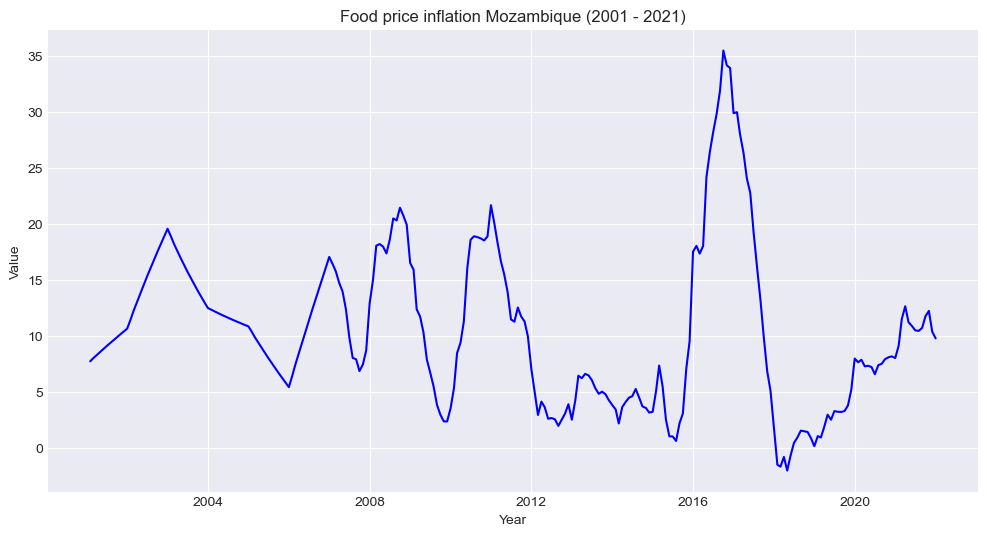

In [5]:
'''VISUALIZE'''
plt.figure(figsize=(12, 6))
plt.title("Food price inflation Mozambique (2001 - 2021)")
plt.ylabel('Value')
plt.xlabel('Year')
plt.plot(cpi_data['Dates'], cpi_data['Value'], color="blue")
plt.show()

## Isolation Forest Setup

In [6]:
def create_IsolationForest_model(df_passed_in):
    data = df_passed_in[['Value']]
    
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)
    
    # see documentation for learning about the IF parameters
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
    model = IsolationForest(max_samples=3500, random_state = 1, contamination= 'auto')
    
    model.fit(data)
    return model

In [7]:
def IsolationForest_prediction(df_passed_in, model):
    
    data = df_passed_in[['Value']]
    
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(data)
    
    data = pd.DataFrame(np_scaled)
    df_passed_in['anomaly_IF'] = list(model.predict(data))
    
    return df_passed_in

In [8]:
# create the IF model for the specific price data
model = create_IsolationForest_model(cpi_data)
# Now, by means of the IF model we can look for the anomalies
cpi_data_with_anomalies = IsolationForest_prediction(cpi_data, model)

In [9]:
cpi_data_with_anomalies['anomaly'] = np.where(cpi_data_with_anomalies['anomaly_IF']==1, False, True)
cpi_data_with_anomalies.drop(['anomaly_IF'], inplace = True, axis=1)

In [10]:
def visualize_anomaly(data, anomaly_col):
    # presets for the axes
    n = len(data)
    x = np.arange(n) 
    y = data[anomaly_col].to_numpy()
    anomaly = data['anomaly'].to_numpy()
    
    '''VISUALIZE it'''
    # set up colors
    # Anomalies "red", Normalies "blue" :-)
    color = ['r' if a else 'b' for a in anomaly]

    # convert time series to line segments
    lines = [((x0,y0), (x1,y1)) for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:])]

    colored_lines = LineCollection(lines, colors=color, linewidths=(2,))

    # plot data
    fig, ax = plt.subplots(1,figsize=(15,8))
    ax.add_collection(colored_lines)
    ax.autoscale_view()
    ax.set_title('Food price inflation Mozambique (2001 - 2021) with anomalies in RED color')
    ax.set_ylabel('Value')
    ax.set_xlabel('data point i')
      
    plt.show()
    

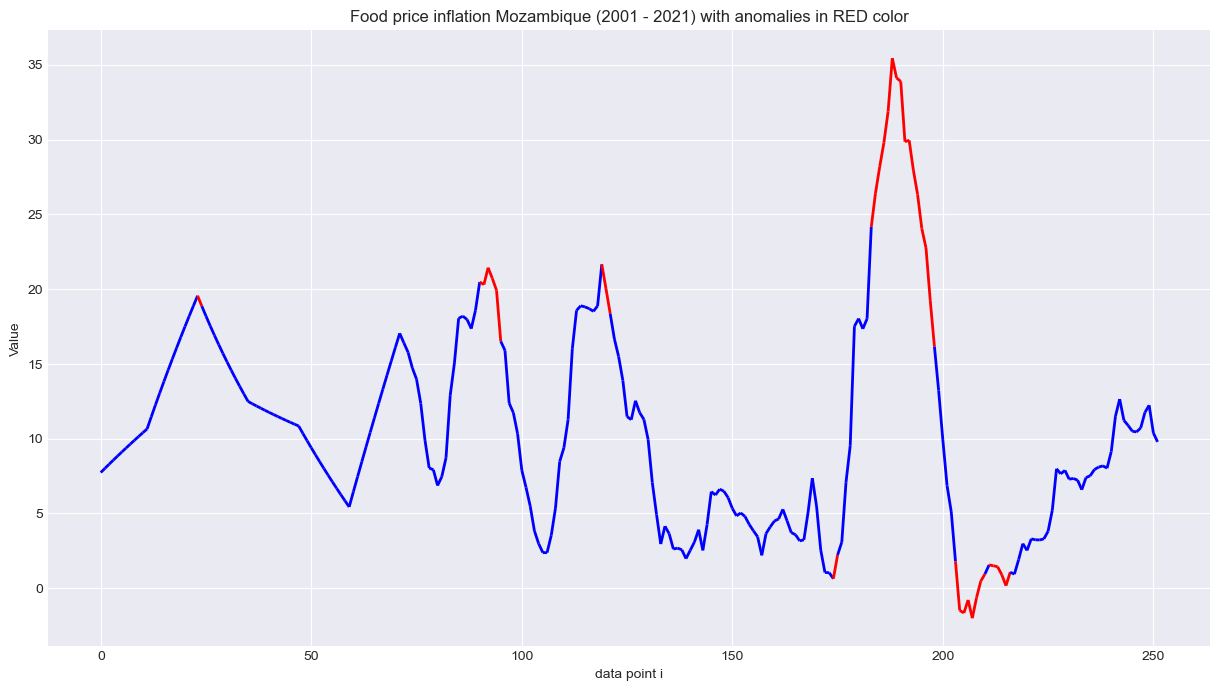

In [11]:
visualize_anomaly(cpi_data_with_anomalies, "Value")

In [12]:
#cpi_data_with_anomalies.head(10)